In [1]:
!pip install tensorflow-gpu==2.7.0 opencv-python tensorflow_datasets matplotlib pycocotools absl-py pydot

     |██▋                             | 39.2 MB 4.2 MB/s eta 0:01:47^C

ERROR: Operation cancelled by user


In [1]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import cv2
import os
import tensorflow_datasets as tfds
import datetime
from coco import COCO
from coco_final_labels import labels as coco_labels
import shutil
from tensorflow.keras.utils import to_categorical
import matplotlib as plt
from tensorflow import keras
import random

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

2022-07-06 21:48:12.385412: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 21:48:12.391112: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 21:48:12.391274: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
BATCH_SIZE = 32
FROM_LOGITS = True
LEARNING_RATE = 0.0001
INFO = "-"
TRAIN_IMAGES = 'data/coco_onehot_train'
VAL_IMAGES = 'data/coco_onehot_val'

CONFIG_STRING = "batch_size: {0} | last_dense: {1} | softmax: {2} | from_logits: {3} | lr: {4} | info: {5}"

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

2022-07-06 21:48:14.250690: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-06 21:48:14.251246: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 21:48:14.251399: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 21:48:14.251494: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 80)                163920    
                                                                 
Total params: 23,728,720
Trainable params: 23,683,280
Non-trainable params: 45,440
_________________________________________________________________


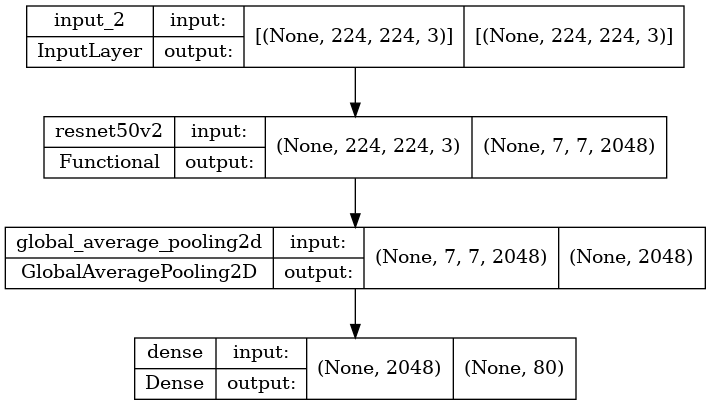

In [4]:

opt = Adam(learning_rate=LEARNING_RATE)
resnet50 = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape = (224,224,3))

input = Input(shape=(224,224,3))
encoder = resnet50(input)
avg_pool = GlobalAveragePooling2D()(encoder)
fc = Dense(len(coco_labels), activation="sigmoid")(avg_pool)
model = Model(input, fc)
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=FROM_LOGITS), optimizer=opt, metrics=METRICS)

model.summary()
tf.keras.utils.plot_model(model, to_file="logs/resnet50/model.png", show_shapes=True, expand_nested=False)

In [8]:
resnet_original = tf.keras.applications.ResNet50V2(input_shape=(224,224,3))
resnet_original.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [7]:
resnet_original_nohead = tf.keras.applications.ResNet50V2(input_shape=(224,224,3), include_top=False)
resnet_original_nohead.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

2
['1401' '0' '17' '14' '61' '0' '317' '745' '292' '44' '20779' '976' '2'
 '945' '77' '1285' '20' '2163' '992' '70' '181' '38' '718' '570' '286'
 '1275' '30' '0' '6' '321' '1480' '193' '118' '229' '1002' '118' '575'
 '349' '0' '734' '332' '710' '702' '97' '339' '187' '481' '1977' '6592'
 '0' '6' '844' '7' '379' '1592' '5' '0' '0' '2086' '103' '33' '403' '0'
 '91' '249' '932' '1381' '103' '307' '25' '744' '623' '221' '59' '958'
 '179' '879' '366' '792' '508' '236' '0' '7' '809' '0' '2605' '0' '310'
 '188' '529' '1945']


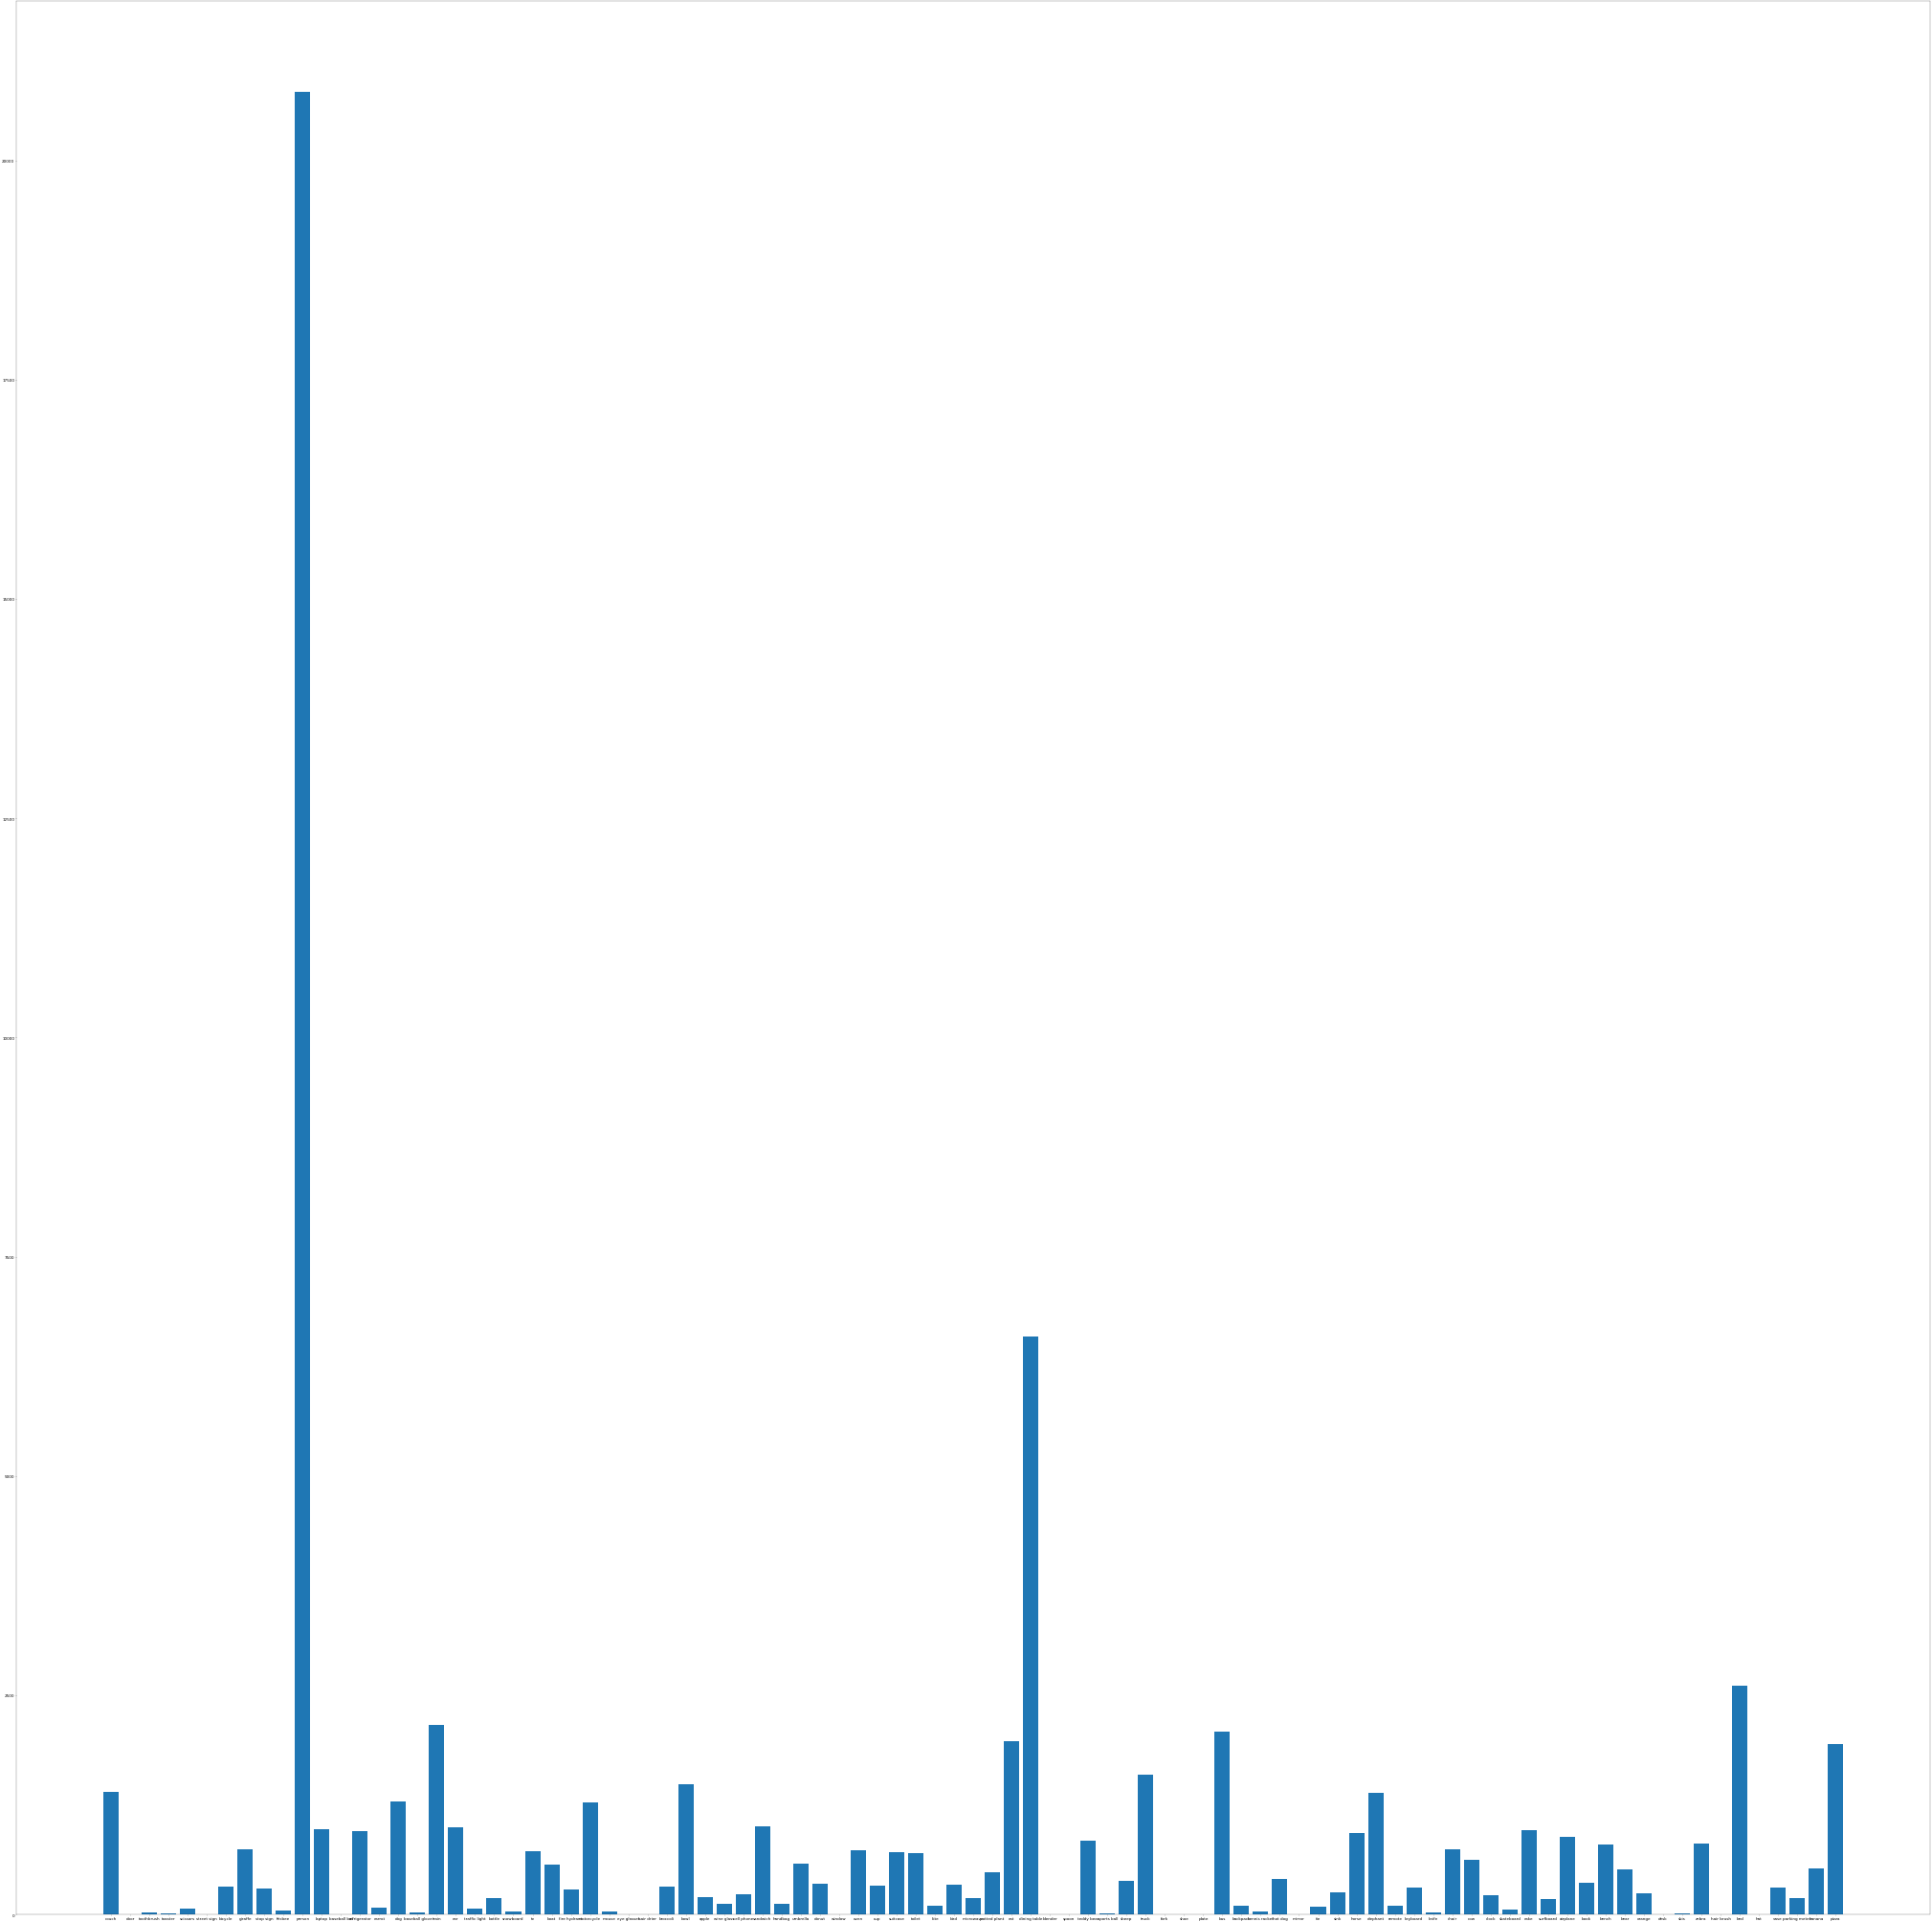

In [5]:
amounts = []
for c in os.listdir("data/coco_onehot_train"):
    amounts.append((c, len(os.listdir("data/coco_onehot_train/{0}".format(c)))))

amounts = np.array(amounts)
plt.rcParams.update({'font.size': 15})
fig = plt.pyplot.figure(figsize=(100,100), dpi=20)
ax = fig.add_axes([0,0,1,1])
ax.bar(amounts[:,0], np.asarray(amounts[:,1],dtype=int))

print(min({x for x in np.asarray(amounts[:,1],dtype=int) if x > 0}))
print(amounts[:,1])

In [6]:
train_files = {}
for d in os.listdir(TRAIN_IMAGES):
    files = os.listdir(f"{TRAIN_IMAGES}/{d}")
    if len(files) > 0:
        train_files[d] = files

print(len(train_files))

val_files = {}
for d in os.listdir(VAL_IMAGES):
    files = os.listdir(f"{VAL_IMAGES}/{d}")
    if len(files) > 0:
        val_files[d] = files

print(len(val_files))

80
70


In [7]:
def load_images(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224,224))
    img = img/255.0
    return img

def preprocess(anchor, label):
    return (load_images(anchor), label)

def get_training_data(epoch_size=1024, training: bool=True):
    X = []
    Y = []

    image_set = train_files if training else val_files
    image_dir = TRAIN_IMAGES if training else VAL_IMAGES

    available_classes = list(image_set.keys())

    for i in range(epoch_size):
        c = random.choice(available_classes)
        anchor = random.choice(image_set[c])
        X.append(f"{image_dir}/{c}/{anchor}")
        index = coco_labels.index(c)
        lbl = np.zeros(len(coco_labels))
        lbl[index] = 1
        Y.append(lbl)

    return (X, Y)

def get_training_dataset(epoch_size=1024, training: bool=True):
    data = get_training_data(epoch_size, training)
    x = tf.data.Dataset.from_tensor_slices(data[0])
    y = tf.data.Dataset.from_tensor_slices(data[1])
    final_data = tf.data.Dataset.zip((x,y))
    processed_data = final_data.map(preprocess)
    return processed_data

In [13]:
print(train_files.keys())

dict_keys(['couch', 'toothbrush', 'toaster', 'scissors', 'bicycle', 'giraffe', 'stop sign', 'frisbee', 'person', 'laptop', 'baseball bat', 'refrigerator', 'carrot', 'dog', 'baseball glove', 'train', 'car', 'traffic light', 'bottle', 'snowboard', 'tv', 'boat', 'fire hydrant', 'motorcycle', 'mouse', 'hair drier', 'broccoli', 'bowl', 'apple', 'wine glass', 'cell phone', 'sandwich', 'handbag', 'umbrella', 'donut', 'oven', 'cup', 'suitcase', 'toilet', 'kite', 'bird', 'microwave', 'potted plant', 'cat', 'dining table', 'spoon', 'teddy bear', 'sports ball', 'sheep', 'truck', 'fork', 'bus', 'backpack', 'tennis racket', 'hot dog', 'tie', 'sink', 'horse', 'elephant', 'remote', 'keyboard', 'knife', 'chair', 'cow', 'clock', 'skateboard', 'cake', 'surfboard', 'airplane', 'book', 'bench', 'bear', 'orange', 'skis', 'zebra', 'bed', 'vase', 'parking meter', 'banana', 'pizza'])


In [8]:
def get_validation_data():
    X = []
    Y = []
    for root, dirs, files in os.walk(VAL_IMAGES):
        for name in files:
            image = os.path.join(root, name)
            index = coco_labels.index(image.split('/')[-2])
            lbl = np.zeros(len(coco_labels))
            lbl[index] = 1
            X.append(image)
            Y.append(lbl)

    x = tf.data.Dataset.from_tensor_slices(X)
    y = tf.data.Dataset.from_tensor_slices(Y)
    final_data = tf.data.Dataset.zip((x,y))
    processed_data = final_data.map(preprocess)
    return processed_data

In [6]:
# def load_images(path):
#     img = tf.io.read_file(path)
#     img = tf.io.decode_jpeg(img, channels=3)
#     img = tf.image.resize(img, [224, 224])
#     img = img/255
#     lbl = tf.strings.split(path, os.path.sep)[-2]
#     lbl = lbl == coco_labels
#     return img, tf.one_hot(tf.argmax(lbl), len(coco_labels))

# tf_dataset = tf.data.Dataset.list_files('coco_onehot_data/*/*')

# AUTOTUNE = tf.data.AUTOTUNE

# val_size = int(len(tf_dataset)*0.1)
# train_ds = tf_dataset.skip(val_size).map(load_images, num_parallel_calls=AUTOTUNE)
# val_ds = tf_dataset.take(val_size).map(load_images, num_parallel_calls=AUTOTUNE)

# train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

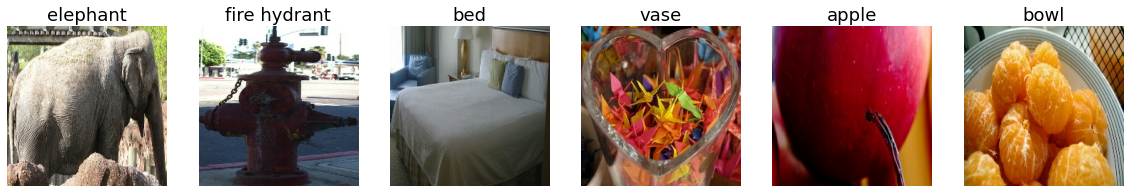

In [11]:
dataset = get_training_dataset(6, False)
dataset = dataset.as_numpy_iterator()

plt.pyplot.figure(figsize=(20,20))
for i in range(6):
    ax = plt.pyplot.subplot(1,6,i+1)
    datatuple = next(dataset)
    plt.pyplot.imshow(datatuple[0])
    label = datatuple[1]
    label = np.where(label == 1)[0][0]
    plt.pyplot.title(coco_labels[label])
    plt.pyplot.axis("off")

In [12]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir logs/resnet50

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'logs/resnet50/{0}'.format(current_time)
weight_dir = 'weights/resnet50/{0}'.format(current_time)

summary_writer = tf.summary.create_file_writer(log_dir)
summary_writer.set_as_default()
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, update_freq=100)
weight_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=weight_dir,
    save_weights_only=False,
    monitor='accuracy',
    mode='max',
    save_best_only=True)

Reusing TensorBoard on port 6006 (pid 101730), started 0:23:46 ago. (Use '!kill 101730' to kill it.)

In [13]:
val_data = get_validation_data()
val_data = val_data.batch(32)
val_data = val_data.prefetch(32)

def train():
    print("Starting training...")

    train_data = get_training_dataset(4096*4)
    train_data = train_data.batch(32)
    train_data = train_data.prefetch(32)

    #loss = siamese_model.fit(train_data, batch_size=32, epochs=20, validation_data=val_data, callbacks=[tensorboard_callback])
    hist_train = model.fit(train_data, batch_size=BATCH_SIZE, validation_data=val_data, callbacks=[tensorboard_callback, weight_callback], epochs=20)

train()

Starting training...
Epoch 1/20


/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
2022-07-06 21:49:23.943798: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-07-06 21:49:24.373223: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-06 21:49:25.620571: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


 99/512 [====>.........................] - ETA: 1:20 - loss: 2.7027 - tp: 2564.0000 - fp: 60879.0000 - tn: 189393.0000 - fn: 604.0000 - accuracy: 0.4343 - precision: 0.0404 - recall: 0.8093 - auc: 0.8755 - prc: 0.3977

2022-07-06 21:49:50.486478: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: weights/resnet50/20220706-214916/assets
512/512 [==============================] - ETA: 0s - loss: 1.2032 - tp: 15464.0000 - fp: 194076.0000 - tn: 1100260.0000 - fn: 920.0000 - accuracy: 0.7184 - precision: 0.0738 - recall: 0.9438 - auc: 0.9726 - prc: 0.6690

/home/bosqnux/Koodit/Oppari/.venv/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


512/512 [==============================] - 168s 315ms/step - loss: 1.2032 - tp: 15464.0000 - fp: 194076.0000 - tn: 1100260.0000 - fn: 920.0000 - accuracy: 0.7184 - precision: 0.0738 - recall: 0.9438 - auc: 0.9726 - prc: 0.6690 - val_loss: 1.0665 - val_tp: 2943.0000 - val_fp: 31323.0000 - val_tn: 210891.0000 - val_fn: 123.0000 - val_accuracy: 0.7224 - val_precision: 0.0859 - val_recall: 0.9599 - val_auc: 0.9796 - val_prc: 0.6143
Epoch 2/20
512/512 [==============================] - 161s 315ms/step - loss: 0.1700 - tp: 16363.0000 - fp: 131886.0000 - tn: 1162450.0000 - fn: 21.0000 - accuracy: 0.9597 - precision: 0.1104 - recall: 0.9987 - auc: 0.9983 - prc: 0.8696 - val_loss: 1.0306 - val_tp: 2962.0000 - val_fp: 27830.0000 - val_tn: 214384.0000 - val_fn: 104.0000 - val_accuracy: 0.7449 - val_precision: 0.0962 - val_recall: 0.9661 - val_auc: 0.9827 - val_prc: 0.5939
Epoch 3/20
512/512 [==============================] - 162s 317ms/step - loss: 0.0260 - tp: 16384.0000 - fp: 122293.0000 - tn: 

In [10]:
resnet.model.save_weights(os.path.join(weight_dir, weight_file.format("_onehot")))

In [12]:

resnet.model.evaluate(validation_ds, verbose=1)


14/14 [==============================] - 2s 151ms/step - loss: 2.2457 - accuracy: 0.6529


[2.2457149028778076, 0.6528735756874084]